# Sudeste Module 3 Exam

### Instructions
Modify this notebook to compose your model. You may use additional `.py` files within this folder, `src/` for composing your framework.

It is discouraged to rename the `notebook.ipynb` for this particular task.

In [1]:
# Write your code here
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from itertools import product


from optimize_SARIMA import optimize_SARIMA

In [2]:
lf = pl.scan_csv('sudeste.csv', try_parse_dates=True)
lf.head().collect()

wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,yr,mo,da,hr,prcp,stp,smax,smin,gbrd,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
i64,str,f64,f64,f64,str,str,str,datetime[μs],date,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 00:00:00,2007-11-06,2007,11,6,0,null,982.5,982.5,981.3,null,29.3,12.1,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 01:00:00,2007-11-06,2007,11,6,1,null,983.2,983.2,982.5,null,29.0,13.5,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 02:00:00,2007-11-06,2007,11,6,2,null,983.5,983.5,983.2,null,27.4,14.0,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 03:00:00,2007-11-06,2007,11,6,3,null,983.7,983.7,983.4,null,25.8,16.9,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
178,"""SÃO GONÇALO""",237.0,-6.835777,-38.311583,"""A333""","""São Gonçalo""","""RJ""",2007-11-06 04:00:00,2007-11-06,2007,11,6,4,null,983.7,983.8,983.6,null,25.4,16.4,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [3]:
lf_wsid_count_per_city = lf.select(['wsid', 'city']).group_by('city', maintain_order=True).n_unique().sort('wsid', descending=True)
lf_wsid_count_per_city.collect()

city,wsid
str,u32
"""Rio de Janeiro""",4
"""Belo Horizonte""",2
"""Campos dos Goytacazes""",2
"""São Gonçalo""",1
"""Vitória""",1
…,…
"""Barra do Turvo""",1
"""Pradópolis""",1
"""Barretos""",1


In [4]:
dropped_columns = ['wsid', 'wsnm', 'inme', 'city', 'prov', 'elvt', 'lat', 'lon']
sao_paulo_lf = lf.filter(pl.col('city') == 'São Paulo').drop(dropped_columns)
sao_paulo_df = sao_paulo_lf.collect().to_pandas()
sao_paulo_df.set_index('mdct', inplace=True)

In [5]:
sao_paulo_df

,date,yr,mo,da,hr,prcp,stp,smax,smin,gbrd,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,,
2006-07-25 00:00:00,2006-07-25,2006,7,25,0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-07-25 01:00:00,2006-07-25,2006,7,25,1,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-07-25 02:00:00,2006-07-25,2006,7,25,2,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-07-25 03:00:00,2006-07-25,2006,7,25,3,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-07-25 04:00:00,2006-07-25,2006,7,25,4,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-30 19:00:00,2016-09-30,2016,9,30,19,NaN,926.4,926.5,926.2,481.327,...,16.9,12.4,15.9,11.8,77.0,77.0,74.0,3.9,143.0,10.1
2016-09-30 20:00:00,2016-09-30,2016,9,30,20,NaN,926.8,926.8,926.3,189.192,...,16.1,12.1,15.1,11.8,81.0,81.0,77.0,3.3,161.0,8.3
2016-09-30 21:00:00,2016-09-30,2016,9,30,21,NaN,927.5,927.5,926.8,33.706,...,15.2,12.0,14.6,11.6,82.0,82.0,80.0,3.0,151.0,7.8


In [6]:
sao_paulo_2015_df = sao_paulo_df[sao_paulo_df.index.year == 2015]
sao_paulo_dec_2015_df = sao_paulo_2015_df[sao_paulo_2015_df.index.month == 12]

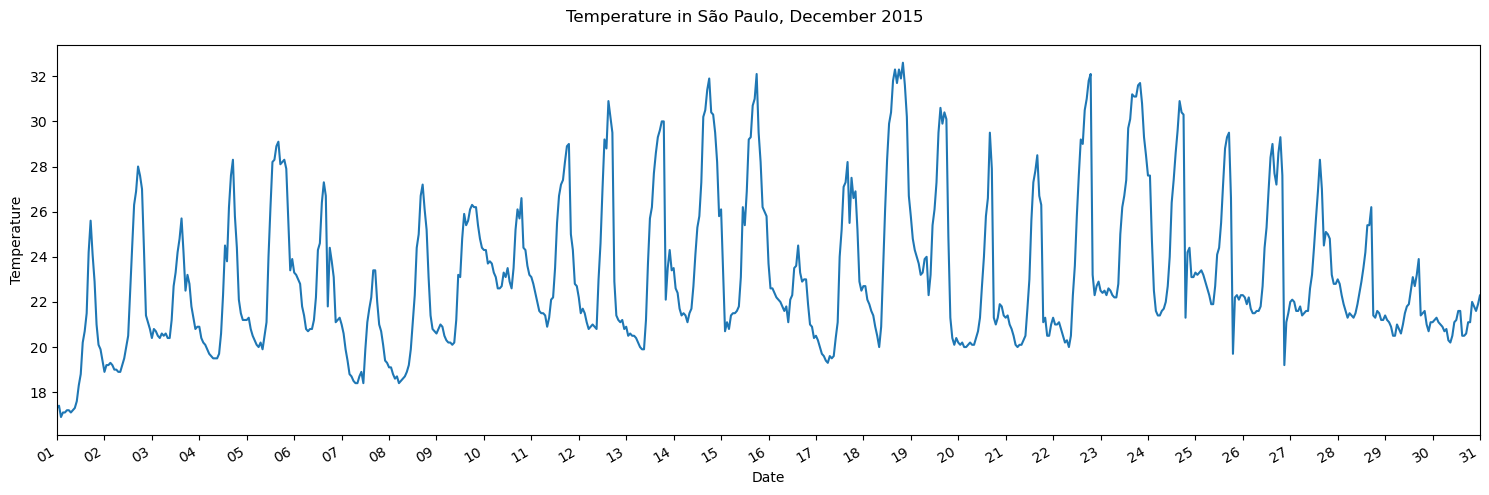

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(sao_paulo_dec_2015_df['temp'])
ax.set_xlim(pd.to_datetime('2015-12-01'), pd.to_datetime('2015-12-31'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
fig.suptitle('Temperature in São Paulo, December 2015')

fig.autofmt_xdate()
plt.tight_layout()

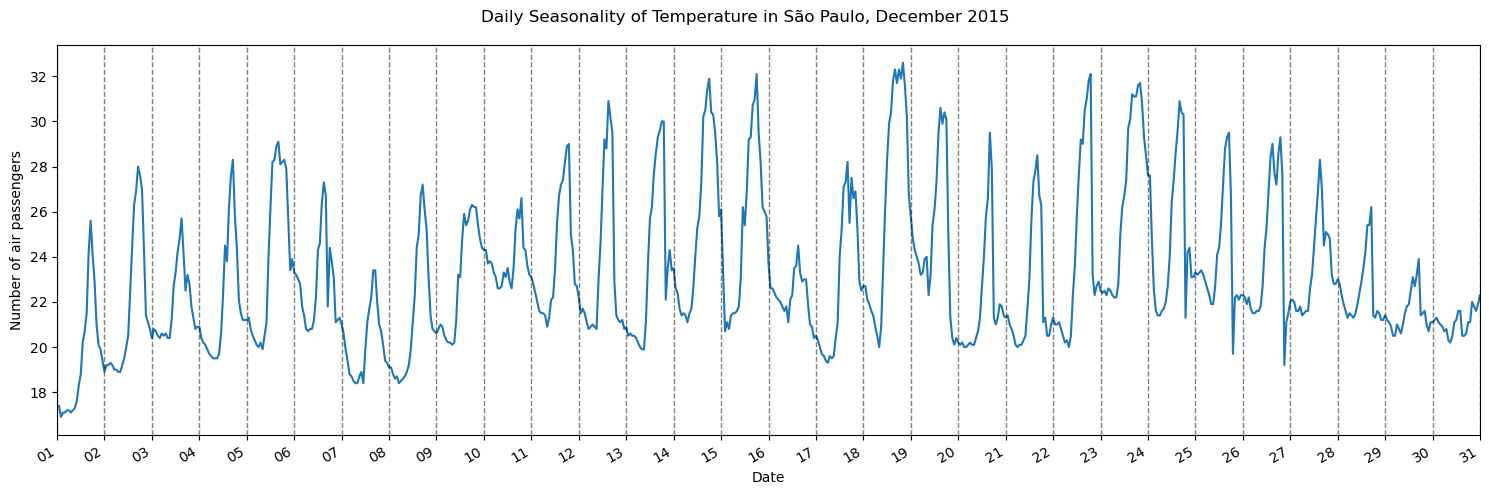

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(sao_paulo_dec_2015_df['temp'])
ax.set_xlim(pd.to_datetime('2015-12-01'), pd.to_datetime('2015-12-31'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
for day in pd.date_range(start='2015-12-01', end='2015-12-31', freq='D'):
    ax.axvline(x=day, linestyle='--', color='black', linewidth=1, alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
fig.suptitle('Daily Seasonality of Temperature in São Paulo, December 2015')

fig.autofmt_xdate()
plt.tight_layout()


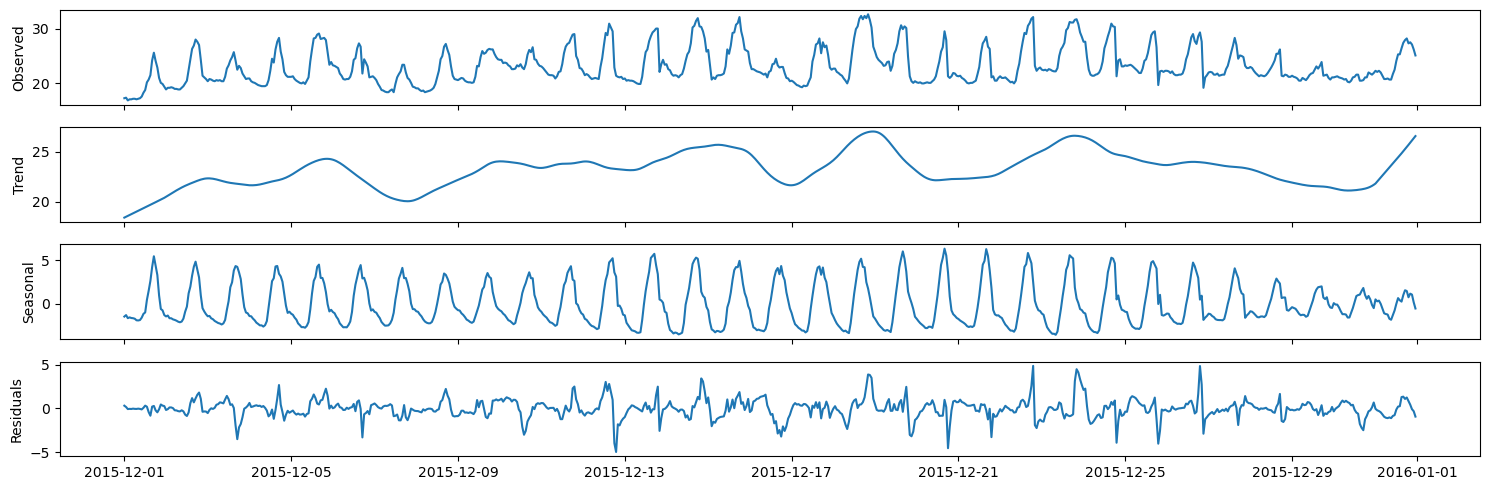

In [9]:
decomposition = STL(sao_paulo_dec_2015_df['temp'], period=24).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15,5))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
plt.tight_layout()

In [10]:
ad_fuller_result = adfuller(sao_paulo_dec_2015_df['temp'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.024311826143162
p-value: 0.032685517344827296


In [11]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = sao_paulo_dec_2015_df['temp'][:-24]

d = 0
D = 0
s = 24

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Shaun\miniconda3\envs\suduste\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency i